In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance

In [4]:
%matplotlib ipympl

RuntimeError: 'ipympl is not a recognised GUI loop or backend name

In [5]:
## Load data
data_folder = './csv/'
# data_file = 'A_left_forelimb_mouse_features_2025-02-25_14-10-48.csv'
# data_file = 'E_left_right_hindlimb_post.csv' # E L vs R vs post > spine 4 ang acceleration -> hip compensation going on healthy part
# data_file = 'AB_LR_combined.csv' # AB combined pre and post > too many clusters, can't see
# data_file = 'AB_LR_combined_post.csv' # AB combined post > too many clusters, can't see
# data_file = 'B_hindlimb.csv' # B pre vs post > small changes
# data_file = 'CE_LR_post.csv'
data_file = 'CE_L_prepost.csv'

full_data = pd.read_csv(data_folder + data_file)

# Drop columns that are not needed
columns_to_drop = ["Mouse", "Number of runs (#)", "Number of steps (#)"]
columns_to_drop.extend([col for col in full_data.columns if "std" in col])
columns_to_drop = [col for col in columns_to_drop if col in full_data.columns]
full_data = full_data.drop(columns=columns_to_drop)

# Identify the categorical and numerical columns
category_col = "Dataset"
numerical_cols = full_data.select_dtypes(include=[np.number]).columns.tolist()

# Encode the categorical column to number
label_encoder = LabelEncoder()
full_data["Dataset_Encoded"] = label_encoder.fit_transform(full_data[category_col])

dataset_mapping = {k: v for k, v in zip(full_data["Dataset_Encoded"].unique(), full_data["Dataset"].unique())}
print(dataset_mapping)
# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(full_data[numerical_cols])

# Convert to df
df_processed = pd.DataFrame(data_scaled, columns=numerical_cols)
df_processed["Dataset"] = full_data["Dataset_Encoded"]

# print(df_processed.head())
print(f"Total number of features: {len(numerical_cols)}")

{np.int64(1): 'E_L_post', np.int64(0): 'C_L_post', np.int64(2): 'Pre'}
Total number of features: 1388


/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(70, 3)


/tmp/ipykernel_71353/3753922353.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


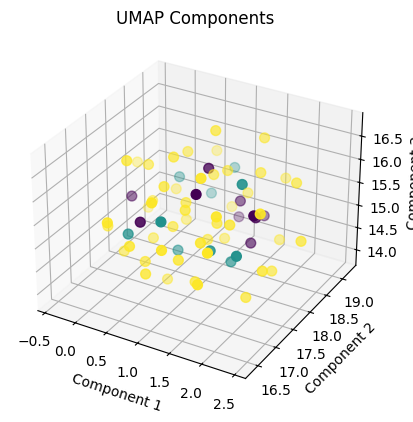

In [6]:
reducer = UMAP(n_components=3, n_neighbors=10, min_dist=0.1, random_state=42)
reducer = UMAP(n_components=3, n_neighbors=10, min_dist=0.1, random_state=42, metric='mahalanobis')
# reducer = UMAP(n_components=3, n_neighbors=10, min_dist=0.1, random_state=42, metric='correlation')
embedding = reducer.fit_transform(df_processed[numerical_cols])

print(embedding.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

datasets = df_processed["Dataset"].unique()
for dataset in datasets:
    mask = df_processed["Dataset"] == dataset

    cmap = plt.get_cmap('viridis')
    colors = cmap(dataset / datasets.max())
    scatter = ax.scatter(
        embedding[mask, 0], 
        embedding[mask, 1], 
        embedding[mask, 2], 
        label=dataset_mapping[dataset], 
        s=50, 
        c=colors,
    )
legend1 = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(datasets))
ax.add_artist(legend1)
ax.set_title("UMAP Components")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

/tmp/ipykernel_71353/1314354165.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter1 = axes[0].scatter(
/tmp/ipykernel_71353/1314354165.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter2 = axes[1].scatter(
/tmp/ipykernel_71353/1314354165.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matche

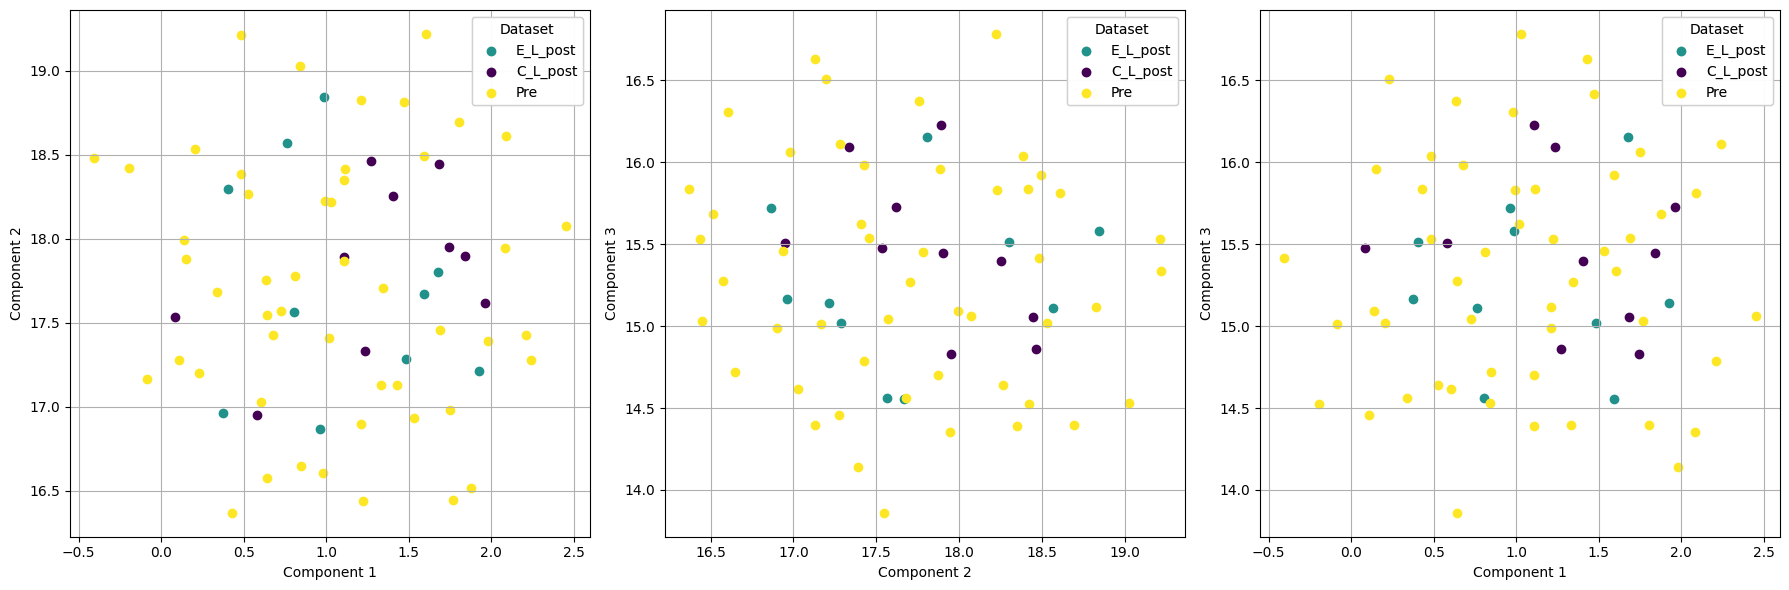

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

datasets = df_processed["Dataset"].unique()

# Component 1 vs 2
for dataset in datasets:
    mask = df_processed["Dataset"] == dataset
    cmap = plt.get_cmap('viridis')
    colors = cmap(dataset / datasets.max())
    scatter1 = axes[0].scatter(
        embedding[mask, 0], embedding[mask, 1], label=dataset_mapping[dataset], c=colors
    )
axes[0].grid(True)
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
# axes[0].set_title("Component 1 vs Component 2")
legend1 = axes[0].legend(loc='upper right', title="Dataset")
axes[0].add_artist(legend1)

# Component 2 vs 3
for dataset in datasets:
    mask = df_processed["Dataset"] == dataset
    cmap = plt.get_cmap('viridis')
    colors = cmap(dataset / datasets.max())
    scatter2 = axes[1].scatter(
        embedding[mask, 1], embedding[mask, 2], label=dataset_mapping[dataset], c=colors
    )
axes[1].grid(True)
axes[1].set_xlabel("Component 2")
axes[1].set_ylabel("Component 3")
# axes[1].set_title("Component 2 vs Component 3")
legend2 = axes[1].legend(loc='upper right', title="Dataset")
axes[1].add_artist(legend2)

# Component 1 vs 3
for dataset in datasets:
    mask = df_processed["Dataset"] == dataset
    cmap = plt.get_cmap('viridis')
    colors = cmap(dataset / datasets.max())
    scatter3 = axes[2].scatter(
        embedding[mask, 0], embedding[mask, 2], label=dataset_mapping[dataset], c=colors
    )
axes[2].grid(True)
axes[2].set_xlabel("Component 1")
axes[2].set_ylabel("Component 3")
# axes[2].set_title("Component 1 vs Component 3")
legend3 = axes[2].legend(loc='upper right', title="Dataset")
axes[2].add_artist(legend3)

plt.tight_layout()
plt.show()


🔍 Training XGBoost to predict UMAP1 from original features...


Top 5 features for UMAP1:
Mean step y acceleration at touchdown - spine 1 (m/s^2)              0.173636
Mean angle during stance - rhindlimb - ankle (°)                     0.119915
Mean angle acceleration at touchdown - tail - tail 3 (°/s^2)         0.064813
Mean angle velocity during swing - rhindlimb - lHindfingers (°/s)    0.063056
Mean step y acceleration at swing - shoulder (m/s^2)                 0.048864
Mean angle value - tail - tail 5 (°)                                 0.048432
Mean phase velocity at peak - spine - spine 2 (°/s)                  0.046157
Mean step x jerk at swing - spine 4 (m/s^3)                          0.039366
Mean step x acceleration during stance - lHindfingers (m/s^2)        0.033848
Mean step x acceleration during stance - base (m/s^2)                0.030284
Mean phase velocity during swing - spine - spine 3 (°/s)             0.028609
Mean step x acceleration at swing - spine 2 (m/s^2)                  0.026690
Mean step x jerk at peak - wrist (m/s^

/tmp/ipykernel_71353/2528723787.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


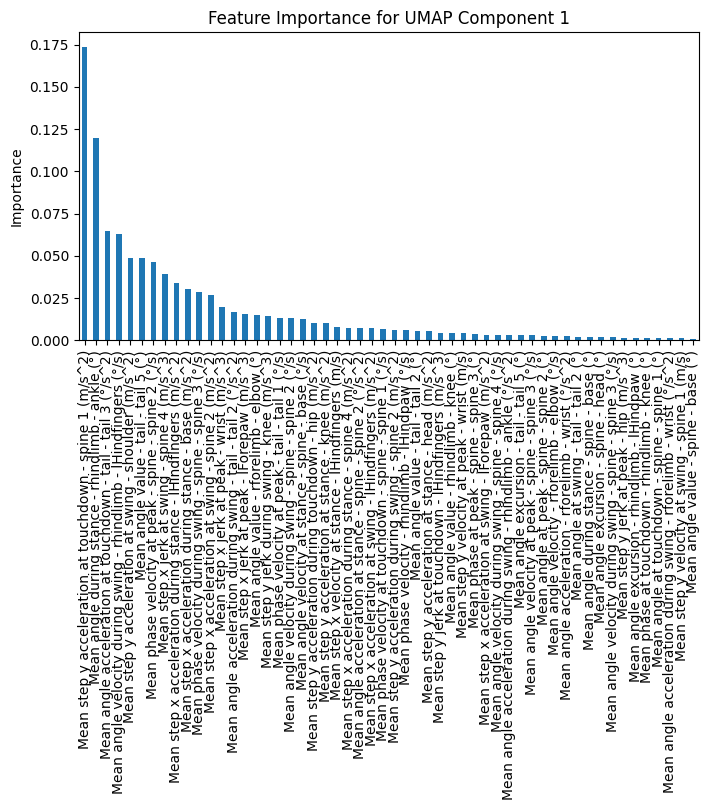

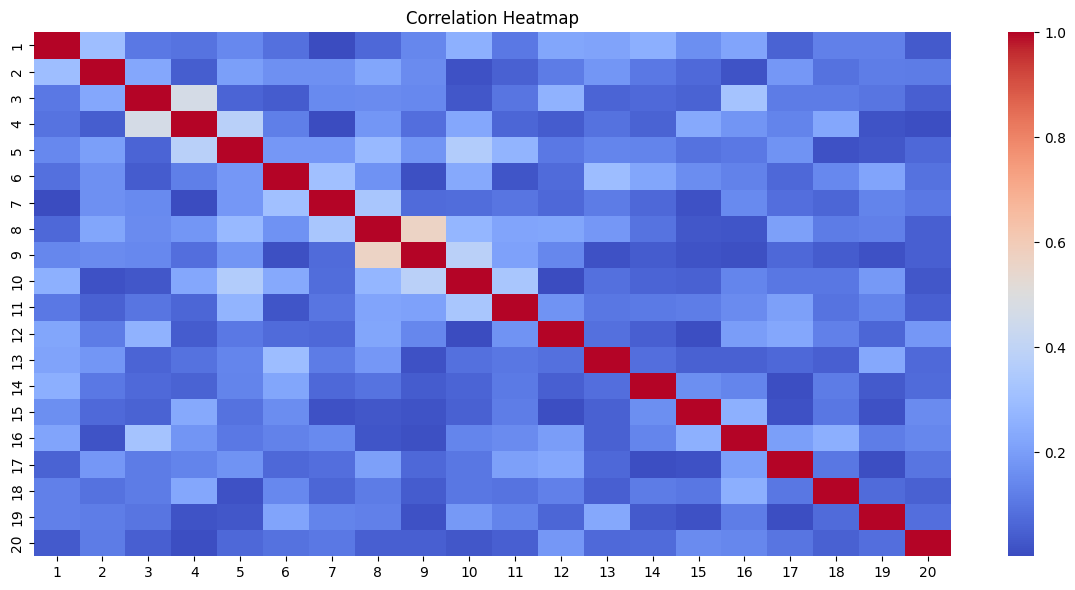


🔍 Training XGBoost to predict UMAP2 from original features...
Top 5 features for UMAP2:
Mean step x acceleration at touchdown - hip (m/s^2)                0.088314
Mean phase velocity at swing - spine - spine 1 (°/s)               0.085060
Mean angle velocity during stance - rhindlimb - ankle (°/s)        0.082369
Mean phase acceleration during stance - spine - spine 1 (°/s^2)    0.073732
Mean step x acceleration during stance - spine 3 (m/s^2)           0.071921
Mean step x acceleration at touchdown - spine 4 (m/s^2)            0.069758
Mean angle velocity at stance - rforelimb - wrist (°/s)            0.060396
Mean phase velocity at stance - spine - spine 3 (°/s)              0.051265
Mean step x jerk during swing - spine 1 (m/s^3)                    0.044650
Mean step x jerk at peak - lForepaw (m/s^3)                        0.035557
Mean phase velocity - rhindlimb - knee (°/s)                       0.033004
Mean step x acceleration at stance - hip (m/s^2)                   0.021237

/tmp/ipykernel_71353/2528723787.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


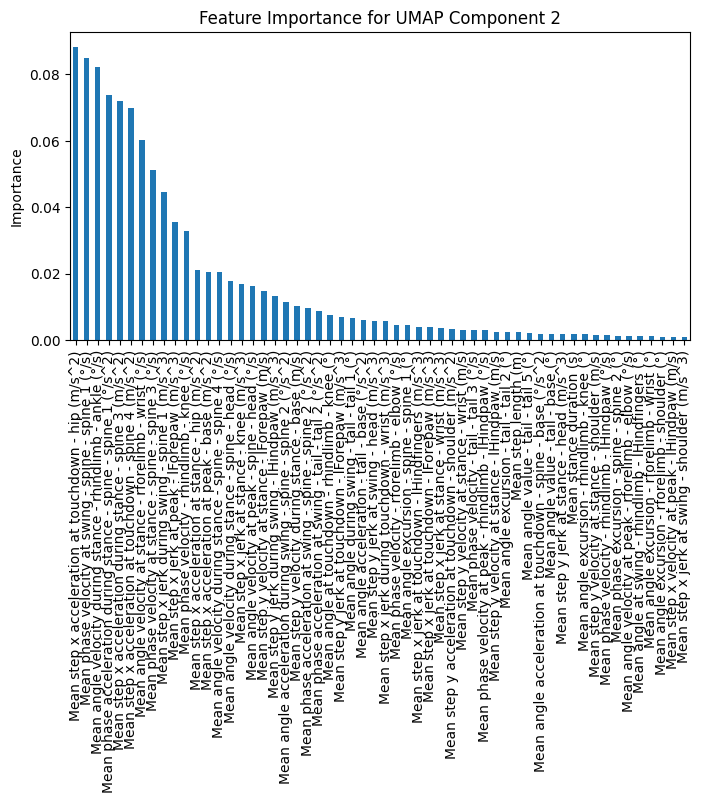

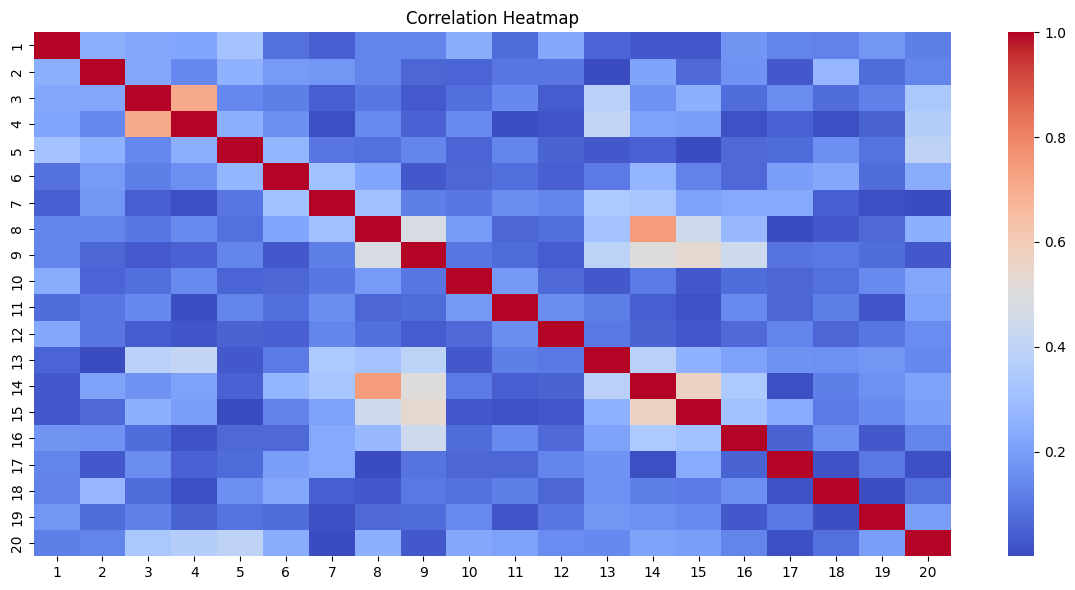


🔍 Training XGBoost to predict UMAP3 from original features...
Top 5 features for UMAP3:
Mean angle at stance - tail - tail 5 (°)                         0.120078
Mean step x acceleration at peak - spine 2 (m/s^2)               0.094430
Mean step y jerk during stance - lForepaw (m/s^3)                0.078103
Mean angle at swing - tail - tail 3 (°)                          0.076209
Mean step x jerk during stance - knee (m/s^3)                    0.062852
Mean step y acceleration at touchdown - wrist (m/s^2)            0.060566
Mean angle velocity at swing - tail - tail 3 (°/s)               0.048618
Mean angle velocity at swing - spine - spine 4 (°/s)             0.045639
Mean step y velocity at stance - lHindpaw (m/s)                  0.039887
Mean phase excursion - rforelimb - wrist (°)                     0.037888
Mean angle at stance - tail - tail 1 (°)                         0.024348
Mean angle acceleration at touchdown - tail - tail 1 (°/s^2)     0.023449
Mean step x acceleratio

/tmp/ipykernel_71353/2528723787.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


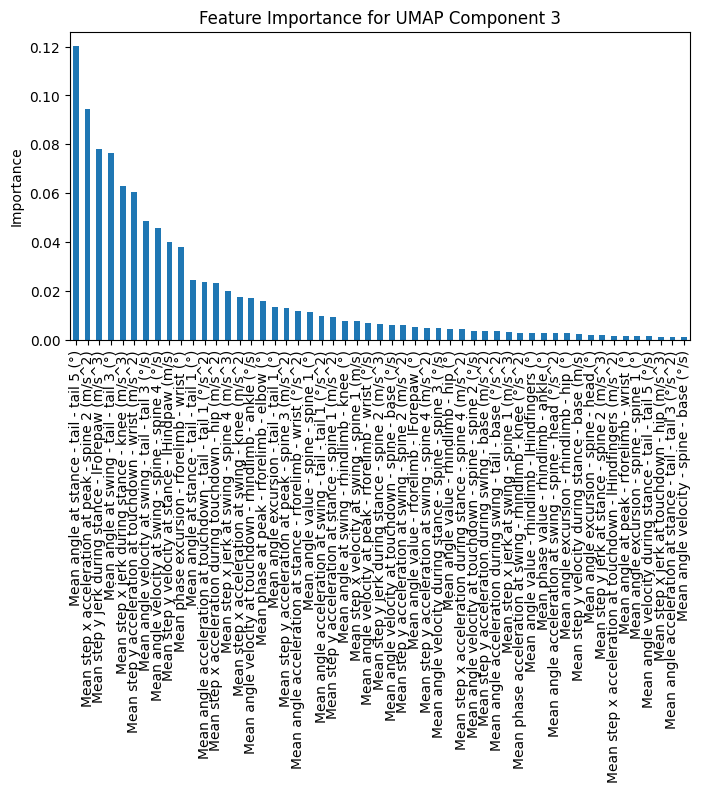

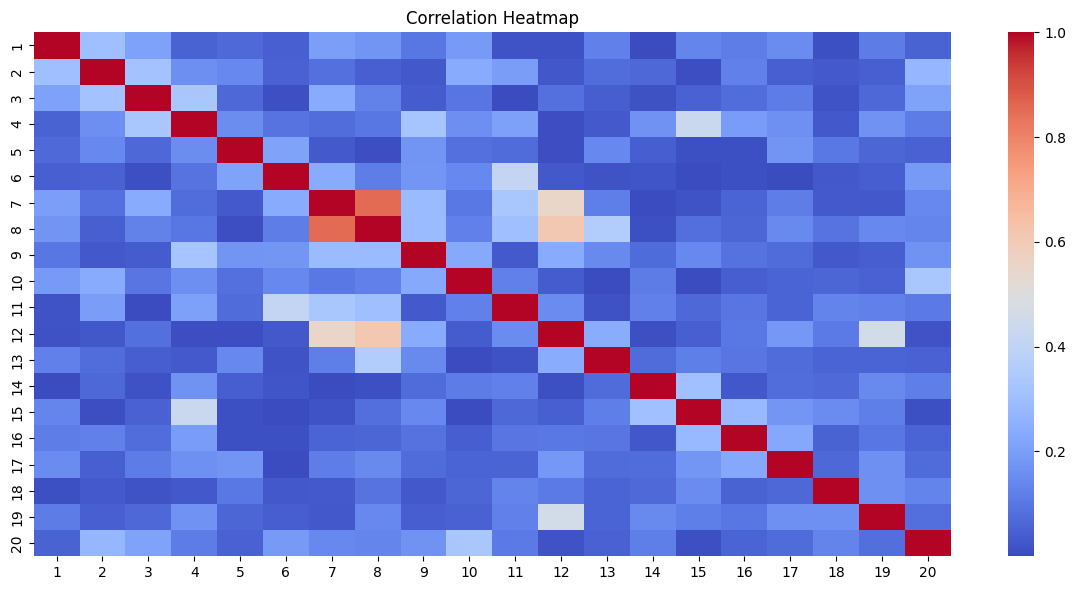

In [8]:
umap_features = ["UMAP1", "UMAP2", "UMAP3"]
embedding_df = pd.DataFrame(embedding, columns=umap_features)

importances = {}

def argsort_sim_mat(sm):
    idx = [np.argmax(np.sum(sm, axis=1))]  # a
    for i in range(1, len(sm)):
        sm_i = sm[idx[-1]].copy()
        sm_i[idx] = -1
        idx.append(np.argmax(sm_i))  # b
    return np.array(idx)

for i, comp in enumerate(umap_features):
    print(f"\n🔍 Training XGBoost to predict {comp} from original features...")
    
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(df_processed[numerical_cols], embedding_df[comp])
    
    importance = model.feature_importances_
    importances[comp] = pd.Series(importance, index=numerical_cols).sort_values(ascending=False)
    # Filter and plot only importances greater than 0
    filtered_importances = importances[comp][importances[comp] > 1e-3]
    
    print(f"Top 5 features for {comp}:")
    print(filtered_importances.head(20))
    # Plot
    plt.figure(figsize=(8, 4))
    filtered_importances.plot(kind='bar')
    plt.title(f"Feature Importance for UMAP Component {i+1}")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    # plot correlation
    plt.figure(figsize=(12, 6))
    top_20_features = filtered_importances.index[:20]
    corr_matrix = df_processed[top_20_features].corr()

    corr_matrix_ids = argsort_sim_mat(corr_matrix.values)
    corr_matrix = corr_matrix.iloc[corr_matrix_ids, corr_matrix_ids]
    corr_matrix = np.abs(corr_matrix)

    sns.heatmap(
        corr_matrix, 
        cmap='coolwarm', 
        annot=False, 
        fmt=".2f", 
        xticklabels=range(1, len(top_20_features) + 1), 
        yticklabels=range(1, len(top_20_features) + 1)
    )
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

In [9]:
## Calculate lasso on the data
lasso = Lasso(alpha=0.1)
lasso.fit(df_processed[numerical_cols], df_processed["Dataset"])

feature_ranking = np.argsort(np.abs(lasso.coef_))[::-1]

top_features = feature_ranking[:10]
print(len(feature_ranking))
print(df_processed[numerical_cols].columns[top_features])

1388
Index(['Mean angle excursion - rhindlimb - ankle (°)',
       'Mean phase value - rhindlimb - lHindpaw (°)',
       'Mean step x jerk during touchdown - wrist (m/s^3)',
       'Mean step y velocity during touchdown - lForepaw (m/s)',
       'Mean angle velocity during swing - rhindlimb - knee (°/s)',
       'Mean step x jerk at stance - spine 4 (m/s^3)',
       'Mean step x jerk at touchdown - knee (m/s^3)',
       'Mean angle at peak - rhindlimb - lHindpaw (°)',
       'Mean step y velocity during swing - spine 3 (m/s)',
       'Mean phase during swing - rforelimb - wrist (°)'],
      dtype='object')


In [10]:
## Calculate lasso on the embeddings of UMAP
lasso1 = Lasso(alpha=0.1).fit(df_processed[numerical_cols], embedding[:, 0])
lasso2 = Lasso(alpha=0.1).fit(df_processed[numerical_cols], embedding[:, 1])
lasso3 = Lasso(alpha=0.1).fit(df_processed[numerical_cols], embedding[:, 2])

feature_importance = np.abs(lasso1.coef_) / np.sum(lasso1.coef_) + np.abs(lasso2.coef_) / np.sum(lasso2.coef_) + np.abs(lasso3.coef_) / np.sum(lasso3.coef_)
feature_ranking = np.argsort(feature_importance)[::-1]

top_features = feature_ranking[:20]
print(len(feature_ranking))
print(df_processed[numerical_cols].columns[top_features])

1388
Index(['Mean step x jerk during swing - spine 1 (m/s^3)',
       'Mean step x jerk at touchdown - lHindfingers (m/s^3)',
       'Mean step x jerk during swing - head (m/s^3)',
       'Mean step x acceleration at touchdown - spine 4 (m/s^2)',
       'Mean phase velocity at peak - rhindlimb - knee (°/s)',
       'Mean angle acceleration at swing - tail - tail 2 (°/s^2)',
       'Mean angle acceleration at peak - tail - tail 2 (°/s^2)',
       'Mean step x acceleration during stance - spine 3 (m/s^2)',
       'Mean phase acceleration at stance - tail - tail 3 (°/s^2)',
       'Mean phase velocity at stance - rhindlimb - lHindpaw (°/s)',
       'Mean angle at peak - rhindlimb - lHindpaw (°)',
       'Mean phase at stance - rforelimb - elbow (°)',
       'Mean step y velocity during swing - knee (m/s)',
       'Mean step y velocity during touchdown - spine 2 (m/s)',
       'Mean step x jerk during stance - spine 2 (m/s^3)',
       'Mean step x jerk at touchdown - base (m/s^3)',
       

In [11]:
## Sanity check: compare LASSO with radomized labels and real labels
## to check if the model is overfitting

# Shuffle the labels
random_embedding = embedding.copy()
shuffle(random_embedding[:,0])

# Fit the model with randomized labels
lasso_random_1 = Lasso(alpha=0.1)
lasso_random_1.fit(df_processed[numerical_cols], random_embedding)

lasso_random_2 = Lasso(alpha=0.1)
lasso_random_2.fit(df_processed[numerical_cols], random_embedding)

lasso_random_3 = Lasso(alpha=0.1)
lasso_random_3.fit(df_processed[numerical_cols], random_embedding)

random_importance = np.abs(lasso_random_1.coef_) / np.sum(lasso_random_1.coef_) + np.abs(lasso_random_2.coef_) / np.sum(lasso_random_2.coef_) + np.abs(lasso_random_3.coef_) / np.sum(lasso_random_3.coef_)
real_importance = feature_importance

correlation = np.corrcoef(random_importance, real_importance)[0, 1]
print(f"Correlation between random and real importance: {correlation:.4f}")
if correlation > 0.5:
    print("The random and real importance are correlated. Probably overfitting")
else:
    print("The random and real importance are not correlated. Probably not overfitting")

Correlation between random and real importance: -0.0087
The random and real importance are not correlated. Probably not overfitting


In [12]:
## Check If LASSO-Selected Features Predict UMAP Space Well
top_feature_names = np.array(numerical_cols)[feature_ranking[:20]]
X_top_features = df_processed[top_feature_names]

# Train Ridge Regression to check predictive power
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_top_features, embedding[:, 0])
predictions = ridge_model.predict(X_top_features)

r2 = r2_score(embedding[:, 0], predictions)
print(f"R2 score for component 1: {r2:.4f}")
if r2 > 0.5:
    print("The model is predicting the UMAP space well")
else:
    print("The model is not predicting the UMAP space well")

R2 score for component 1: 0.3775
The model is not predicting the UMAP space well


In [13]:
## Test different alpha values (regularization)
alphas = [0.1, 0.2, 0.5, 0.05, 0.001]
for alpha in alphas:
    lasso_test_1 = Lasso(alpha=alpha).fit(df_processed[numerical_cols], embedding[:, 0])
    lasso_test_2 = Lasso(alpha=alpha).fit(df_processed[numerical_cols], embedding[:, 1])
    lasso_test_3 = Lasso(alpha=alpha).fit(df_processed[numerical_cols], embedding[:, 2])
    selected_features = np.abs(lasso_test_1.coef_) / np.sum(lasso_test_1.coef_) + np.abs(lasso_test_2.coef_) / np.sum(lasso_test_2.coef_) + np.abs(lasso_test_3.coef_) / np.sum(lasso_test_3.coef_)
    selected_ranking = np.argsort(selected_features)[::-1]
    
    intersecting_features = np.isin(selected_ranking, feature_ranking) & (selected_features > 0) & (feature_importance > 0)
    print(f"Alpha: {alpha}:")
    print(f"Number of intersecting features: {np.sum(intersecting_features)}")
    print(f"Intersecting features: {df_processed[numerical_cols].columns[selected_ranking[intersecting_features]]}")

Alpha: 0.1:
Number of intersecting features: 43
Intersecting features: Index(['Mean angle acceleration at peak - spine - spine 2 (°/s^2)',
       'Mean step x acceleration at peak - lHindfingers (m/s^2)',
       'Mean phase excursion - rforelimb - shoulder (°)',
       'Mean angle value - spine - spine 2 (°)',
       'Mean step y acceleration during stance - hip (m/s^2)',
       'Mean step x acceleration during swing - spine 4 (m/s^2)',
       'Mean phase acceleration - spine - spine 1 (°/s^2)',
       'Mean angle acceleration - rhindlimb - hip (°/s^2)',
       'Mean step x velocity at stance - lHindfingers (m/s)',
       'Mean phase acceleration - rhindlimb - knee (°/s^2)',
       'Mean step x velocity at stance - spine 4 (m/s)',
       'Mean phase velocity during swing - rhindlimb - ankle (°/s)',
       'Mean phase excursion - spine - spine 2 (°)',
       'Mean phase velocity during swing - rforelimb - shoulder (°/s)',
       'Mean angle velocity - tail - tail 5 (°/s)',
       'Mean 

/tmp/ipykernel_71353/4148366178.py:7: RuntimeWarning: invalid value encountered in divide
  selected_features = np.abs(lasso_test_1.coef_) / np.sum(lasso_test_1.coef_) + np.abs(lasso_test_2.coef_) / np.sum(lasso_test_2.coef_) + np.abs(lasso_test_3.coef_) / np.sum(lasso_test_3.coef_)
/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.900e-03, tolerance: 2.994e-03
  model = cd_fast.enet_coordinate_descent(
/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

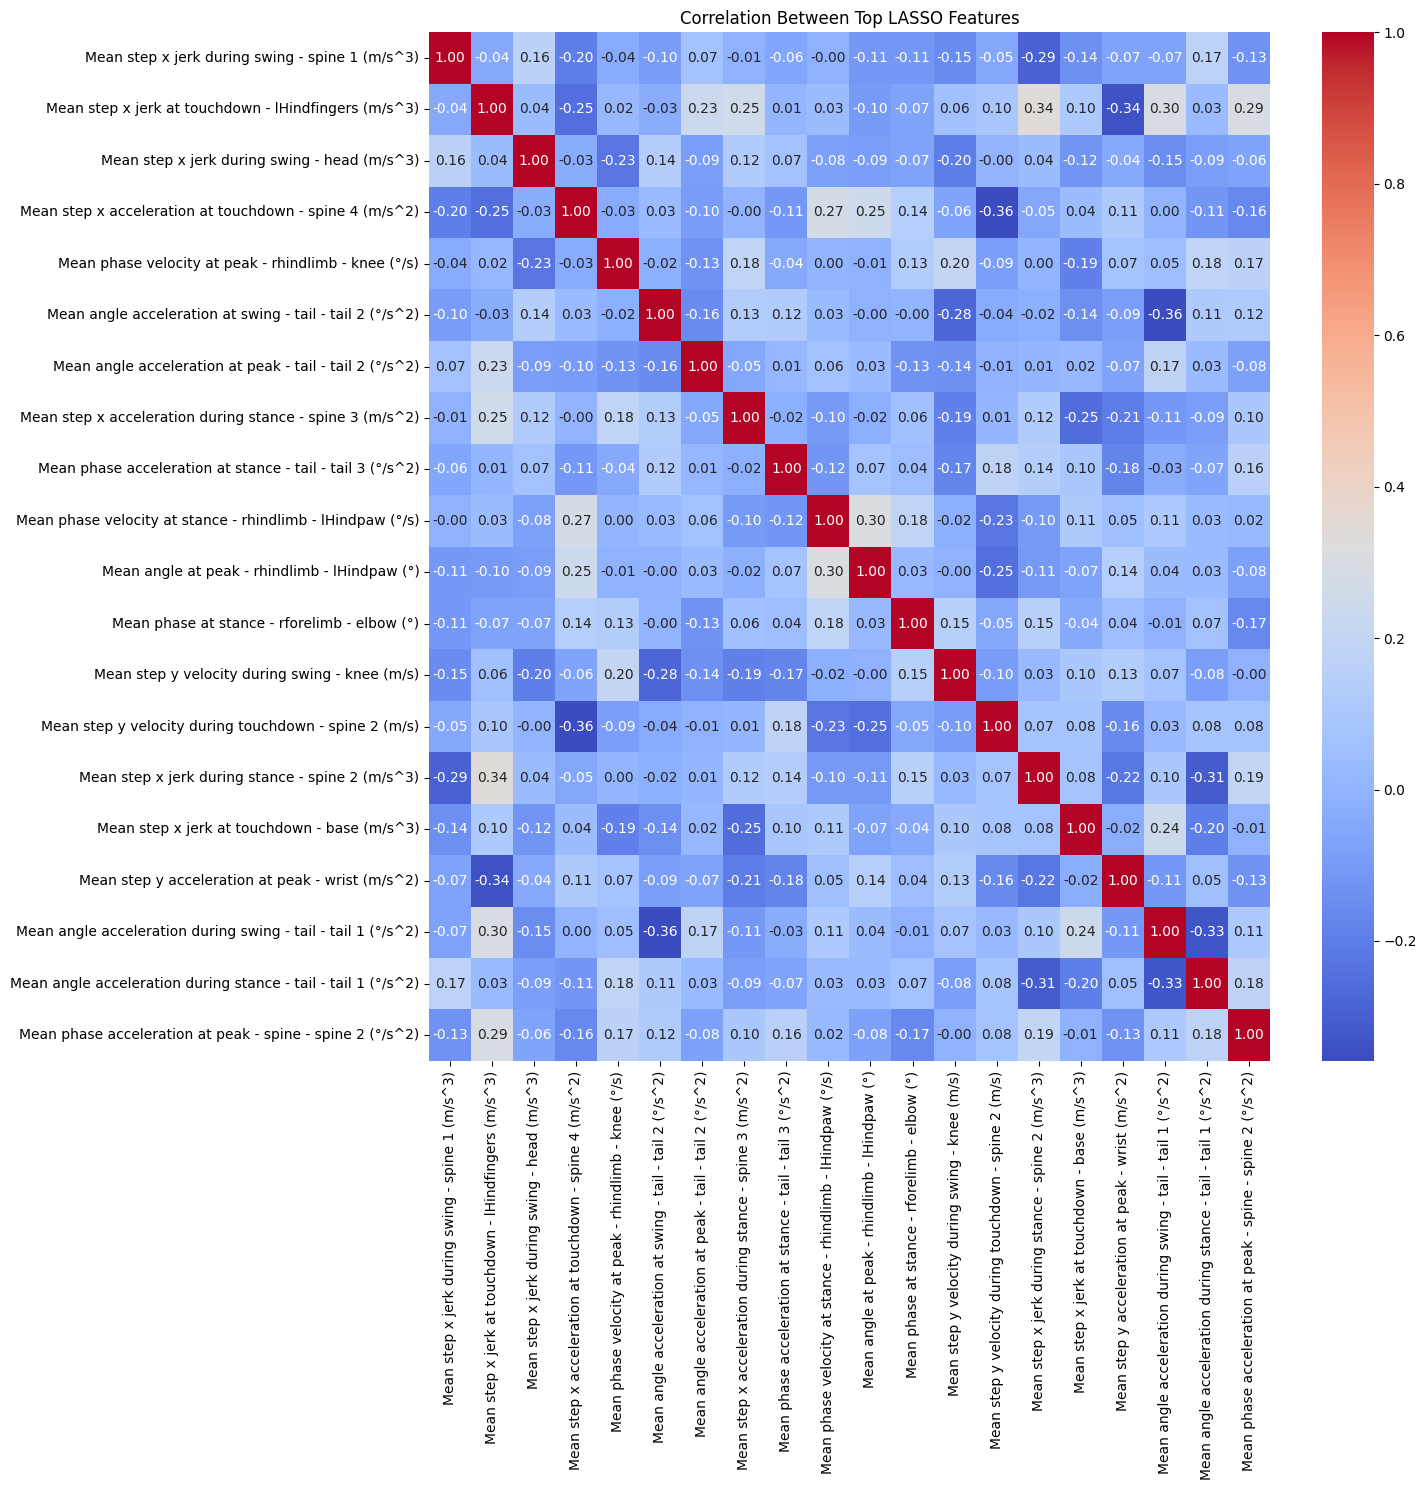

In [14]:
## Check feature redundancy
# If selected features are highly correlated, LASSO is dropping some redundant features.
# If selected features have low correlation, LASSO is picking independent important features.
corr_matrix = df_processed[top_feature_names].corr()

# Plot heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Top LASSO Features")
plt.tight_layout()
plt.show()

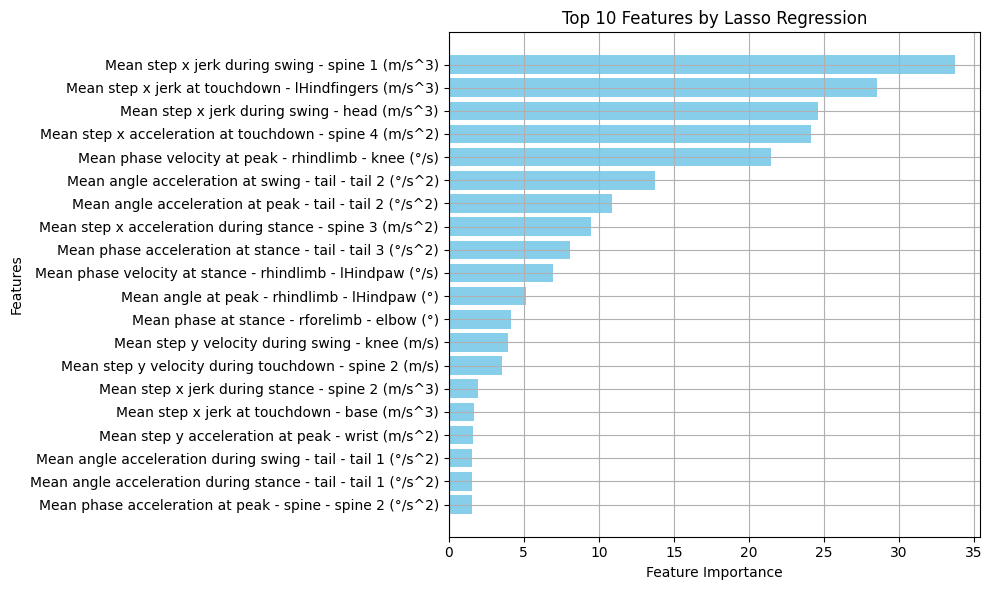

In [15]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(
    df_processed[numerical_cols].columns[top_features][::-1],
    feature_importance[top_features][::-1],
    color='skyblue'
)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Features by Lasso Regression")
plt.grid()
plt.tight_layout()
plt.show()


/tmp/ipykernel_71353/620004883.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


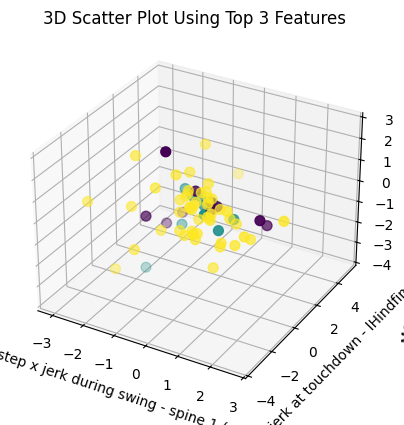

In [16]:
# Extract the top 3 features
top_3_features = df_processed[numerical_cols].columns[top_features[:3]]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

datasets = df_processed["Dataset"].unique()
# Plot the data points
for dataset in datasets:
    mask = df_processed["Dataset"] == dataset

    cmap = plt.get_cmap('viridis')
    colors = cmap(dataset / datasets.max())
    scatter = ax.scatter(
        df_processed[top_3_features[0]][mask],
        df_processed[top_3_features[1]][mask],
        df_processed[top_3_features[2]][mask],
        label=dataset_mapping[dataset], 
        s=50, 
        c=colors,
    )

# Add labels and title
ax.set_xlabel(top_3_features[0])
ax.set_ylabel(top_3_features[1])
ax.set_zlabel(top_3_features[2])
ax.set_title("3D Scatter Plot Using Top 3 Features")

# Add a legend
# legend_labels = [dataset_mapping[label] for label in df_processed["Dataset"].unique()]
# scatter.legend_elements = lambda: ([], legend_labels)
legend1 = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(datasets))
ax.add_artist(legend1)
plt.show()

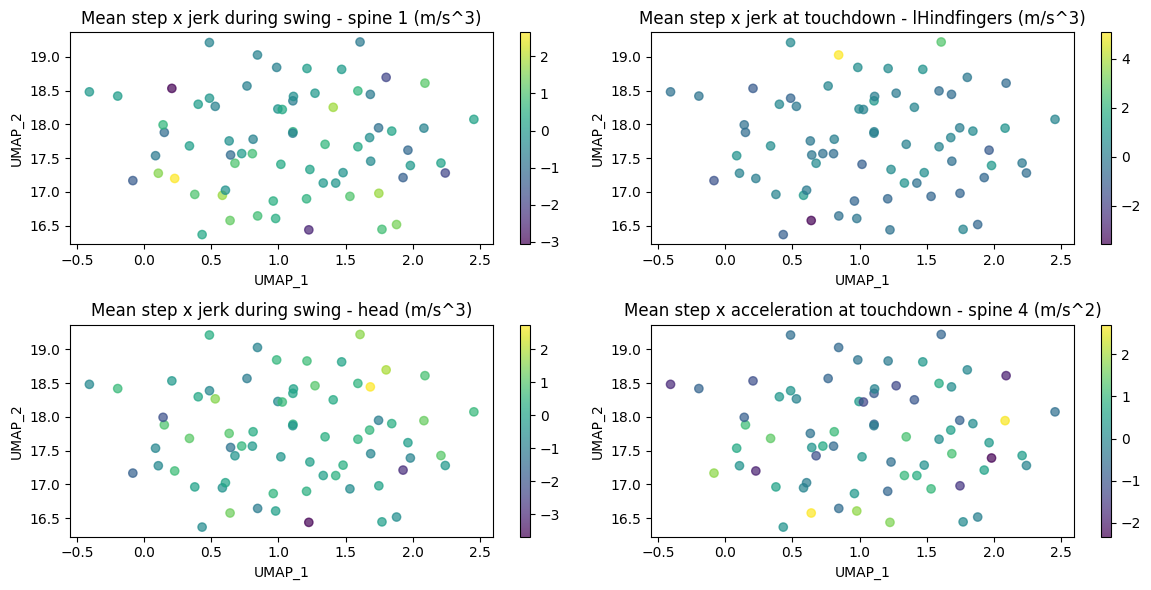

In [17]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(df_processed[numerical_cols].columns[top_features[:4]]):  # Show top 4 features
    plt.subplot(2, 2, i + 1)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=df_processed[feature], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter)
    plt.xlabel("UMAP_1")
    plt.ylabel("UMAP_2")
    plt.title(feature)
plt.tight_layout()
plt.show()